# Analysis functions

In [51]:
import numpy as np
import re
from matplotlib import pyplot as plt
import pandas as pd

color_scheme = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
                               '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def timeToSec(time):
    pc = re.split(':',time)
    return int(pc[0])*3600 + int(pc[1])*60 + int(pc[2])
  
#Helper funtions
def to_seconds(time_series):
  split_string = lambda timestring: re.split(':', timestring)
  time = [float(split_string(value)[0])*3600 + float(split_string(value)[1])*60 + float(split_string(value)[2]) for value in time_series]
  return time

def lookupCondition(columnHeader, conds):
    keys = conds.keys()
    count = 0
    out = ""
    for e in conds.values():
        if columnHeader in e:
            count += 1
            out = list(conds.keys())[list(conds.values()).index(e)]
    assert(count <= 1)
    
    return out
  
def getEndpoint(level, x, data, conditions):
    averages = []

    for i, c in enumerate(data.columns):
        col = c
        if lookupCondition(col, conditions) == level:
            y = [float(i) for i in data[col].values]
            avg = np.average(y[-10:])
            averages.append(avg)

    df = pd.DataFrame(averages).T
    df.columns = ['Average '+str(i+1) for i in range(len(averages))]
    df.insert(0, "Level", level)  # Insert the level name as the first column
    df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
    df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

    return df
  
  
def plotCalibratedAverages(level, x, ax, data, conditions, fit, color_dict, format_dict=None):
    data_list = []
    for i, c in enumerate(data.columns):
        col = c 
        if i>= 2 and lookupCondition(col, conditions) == level:
            ynew = [(float(x) - fit[0])/fit[1] for x in data[col].values]
            data_list.append(ynew)
            
    data_array = np.array(data_list)
    y_mean = np.mean(data_array, axis=0)
    y_std = np.std(data_array, axis=0)
    
    lab = 'Av' + level
    color = color_dict[level] if level in color_dict else 'blue' # set default color to blue

    if format_dict is None:
        format_dict = {'point_size': 1, 'point_opacity': 0.6, 'fill_opacity': 0.5}

    point_size = format_dict.get('point_size', 1)
    point_opacity = format_dict.get('point_opacity', 0.6)
    fill_opacity = format_dict.get('fill_opacity', 0.5)

    ax.scatter(x, y_mean, label=lab, color=color, alpha=point_opacity, s=[point_size]*len(y_mean))
    ax.fill_between(x, y_mean - y_std, y_mean + y_std, color=color, alpha=fill_opacity)

  
def completion_at_time(data,
                      control_data,
                      casc_data,
                      time_list_seconds,
                      time_in_seconds,
                      conditions,
                      control_conditions,
                      casc_conditions,
                      base_line_level,
                      triggered_level,
                      experimental_level,
                      verbose = False):
  data = data
  conditions = conditions
  control_data = control_data
  control_conditions = control_conditions

  def progegate_uncertainty_averaged_stddev(std_dev_list):
    return np.sqrt(sum(s**2 for s in std_dev_list)/(len(std_dev_list)**2))

  def average_last_n_with_std(n, average_series, std_series):
    av = average_series[-n:].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[-n:].values)
    return av, std
  def average_first_n_with_std(n, average_series, std_series):
    av = average_series[:n].mean()
    std = progegate_uncertainty_averaged_stddev(std_series[:n].values)
    return av, std
  def calculate_completion_level(V, T, B):
    return (float(V) - float(B))/(float(T) - float(B))
  def series_av_and_std(dat, cond, level_name):
    target_columns = cond[level_name]
    dat[target_columns] = dat[target_columns].apply(pd.to_numeric)
    average_by_point = dat[target_columns].mean(axis=1)
    std_by_point = dat[target_columns].std(axis=1)
    return average_by_point, std_by_point

  #Get the x-values in seconds
  x = time_list_seconds
  #Fine the index of the first datapoint greater than time in seconds
  desired_time_index = min([i for i, time in enumerate(x) if time >= time_in_seconds])
  #Fist calculate baseline average and uncertainty at LAST AVAILABLE 5 DATAPOINTS
  base_line_average, base_line_std = average_first_n_with_std(5, *series_av_and_std(control_data, control_conditions, base_line_level))
  #Next calculate the triggering average and uncerainty at LAST 5 AVAILABLE DATAPOINTS
  triggered_average, triggered_std = average_last_n_with_std(5, *series_av_and_std(casc_data, casc_conditions, triggered_level))
  completion_levels = []
  for l_name in conditions[experimental_level]:
    completion_levels += [calculate_completion_level(data[l_name][desired_time_index], triggered_average, base_line_average)]

  if verbose:
    print(f"{experimental_level} : {np.average(completion_levels)} +/- {np.std(completion_levels)}")
  return np.average(completion_levels), np.std(completion_levels)


def getInitial(level, x, data, conditions):
  averages = []

  for i, c in enumerate(data.columns):
      col = c
      if lookupCondition(col, conditions) == level:
          y = [float(i) for i in data[col].values]
          avg = np.average(y[0:10])
          averages.append(avg)

  df = pd.DataFrame(averages).T
  df.columns = ['Average '+str(i+1) for i in range(len(averages))]
  df.insert(0, "Level", f"{level} init")  # Insert the level name as the first column
  df['Row Average'] = df.iloc[:, 1:].mean(axis=1)  # Compute the mean excluding the "Level" column
  df['Row Std'] = df.iloc[:, 1:].std(axis=1)  # Compute the std excluding the "Level" column

  return df

# Importing data

In [52]:
UW_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_controls = {'R alone' : ['B10', 'C10', 'D10'], #actually cascade alone
                          'R(nn) alone' : ['E10', 'F10', 'G10']}
offset_UW_controls = 0
t_UW_controls = [timeToSec(t) + offset_UW_controls for t in UW_controls['Time'].values]

UW_casc_controls = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc_controls = {'Cascade' : ['B5', 'C5', 'D5'],
                                'Cascade(nn)' : ['E5', 'F5', 'G5']}
offset_UW_casc_controls = 0
t_UW_casc_controls = [timeToSec(t) + offset_UW_casc_controls for t in UW_casc_controls['Time'].values]


UW_trig = pd.read_csv('UW_Cascades.csv')
conditions_UW_trig = {'N50_25uM nat' : ['B9', 'C9', 'D9'],
                      'N50_25uM nn' : ['E9', 'F9', 'G9']}
offset_UW_trig = 190
t_UW_trig = [timeToSec(t) + offset_UW_trig for t in UW_trig['Time'].values]


UW_casc = pd.read_csv('UW_Cascades.csv')
conditions_UW_casc = {'N50_25uM nat' : ['B8', 'C8', 'D8'],
                     'N50_25uM nn' : ['E8', 'F8', 'G8']}
offset_UW_casc = 190
t_UW_casc = [timeToSec(t) + offset_UW_casc for t in UW_casc['Time'].values]


UW_no = pd.read_csv('UW_Cascades.csv')

conditions_UW_no = {'N50_25uM nat' : ['B13', 'C13', 'D13'],
             'N50_25uM nn' : ['E13', 'F13', 'G13']}
offset_UW_no = 190
t_UW_no = [timeToSec(t) + offset_UW_no for t in UW_no['Time'].values]



TUM_controls = pd.read_csv('TUM_Controls.csv')
conditions_TUM_controls = {'buffer alone' : ['Buffer_1',	'Buffer_2',	'Buffer_3'],
                          'R alone' : ['R_1',	'R_2',	'R_3'],
                          'R(nn) alone' : ['R(nn)_1',	'R(nn)_2',	'R(nn)_3']}
offset_TUM_controls = 0
t_TUM_controls = [int(t) + offset_TUM_controls for t in TUM_controls['time'].values]

TUM_casc_controls = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_casc_controls = {'Cascade' : ['Cascade_1',	'Cascade_2',	'Cascade_3'],
                                'Cascade(nn)' : ['Cascade(nn)_1',	'Cascade(nn)_2',	'Cascade(nn)_3']}
offset_TUM_casc_controls = 0
t_TUM_casc_controls = [int(t) + offset_TUM_casc_controls for t in TUM_casc_controls['time'].values]


TUM_no = pd.read_csv('TUM_Cascades_NoIncub.csv')
conditions_TUM_no = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_no = 0
t_TUM_no = [int(t) + offset_TUM_no for t in TUM_no['time'].values]


TUM_trig = pd.read_csv('TUM_Cascades_TrigIncub.csv')
conditions_TUM_trig = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                     'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                     'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                     'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                     'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                     'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                     'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                     'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                     'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                     'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                     }
offset_TUM_trig = 0
t_TUM_trig = [int(t) + offset_TUM_trig for t in TUM_trig['time'].values]


TUM_casc = pd.read_csv('TUM_Cascades_CascIncub.csv')
conditions_TUM_casc = {'N25_10uM nat' : ['N25-10µM_1',	'N25-10µM_2',	'N25-10µM_3'],
                       'N25_25uM nat' : ['N25-25µM_1',	'N25-25µM_2',	'N25-25µM_3'],
                       'N50_10uM nat' : ['N50-10µM_1',	'N50-10µM_2',	'N50-10µM_3'],
                       'N50_25uM nat' : ['N50-25µM_1',	'N50-25µM_2',	'N50-25µM_3'],
                       'N25_10uM nn' : ['N25-10µM(nn)_1',	'N25-10µM(nn)_2',	'N25-10µM(nn)_3'],
                       'N25_25uM nn' : ['N25-25µM(nn)_1',	'N25-25µM(nn)_2',	'N25-25µM(nn)_3'],
                       'N50_10uM nn' : ['N50-10µM(nn)_1',	'N50-10µM(nn)_2',	'N50-10µM(nn)_3'],
                       'N50_25uM nn' : ['N50-25µM(nn)_1',	'N50-25µM(nn)_2',	'N50-25µM(nn)_3'],
                        'RNA N183 5uM nat' : ['RNA N183 5µM_1',	'RNA N183 5µM_2',	'RNA N183 5µM_3'],
                        'RNA N183 5uM(nn)' : ['RNA N183 5µM(nn)_1',	'RNA N183 5µM(nn)_2',	'RNA N183 5µM(nn)_3']
                        }
offset_TUM_casc = 0
t_TUM_casc = [int(t) + offset_TUM_casc for t in TUM_casc['time'].values]

# Processing TUM data

## No incubation

In [53]:
t1 = t_TUM_controls
data1 = TUM_controls
conditions1 = conditions_TUM_controls
t2 = t_TUM_casc_controls
data2 = TUM_casc_controls
conditions2 = conditions_TUM_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i,l in enumerate(levels1):
    dfArray.append(getEndpoint(l, t1, data1, conditions1))
for i,l in enumerate(levels2):
    dfArray.append(getEndpoint(l, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
2,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
3,Cascade,16789.3,17054.0,16423.0,16755.433333,258.715369
4,Cascade(nn),16496.0,15884.3,16110.8,16163.700000,252.511425


In [54]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

N25_10uM nat : 0.6531273568957894 +/- 0.005409982312041719
N25_25uM nat : 0.4029127981066811 +/- 0.029714777471392763
N50_10uM nat : 0.14494811578372468 +/- 0.016367059432784083
N50_25uM nat : 0.0512444409768276 +/- 0.010265932079351937
N25_10uM nn : 0.8527286702536511 +/- 0.03945211887283542
N25_25uM nn : 0.7525859229164379 +/- 0.052223537163015935
N50_10uM nn : 0.4491380256945207 +/- 0.03524339969367097
N50_25uM nn : 0.18074558032282861 +/- 0.015259676165078744
diff_N25_10uM: 0.1996013133578617 +/- 0.039821320824062846
diff_N25_25uM: 0.34967312480975676 +/- 0.060085487715348516
diff_N50_10uM: 0.30418990991079603 +/- 0.03885843353049803
diff_N50_25uM: 0.12950113934600102 +/- 0.018391494722314973
RNA N183 5uM nat : 0.7719279082468594 +/- 0.022145460982589807
RNA N183 5uM(nn) : 0.7816805804790511 +/- 0.018119931932807372
diff_rna_5uM: 0.009752672232191673 +/- 0.0286138668372693


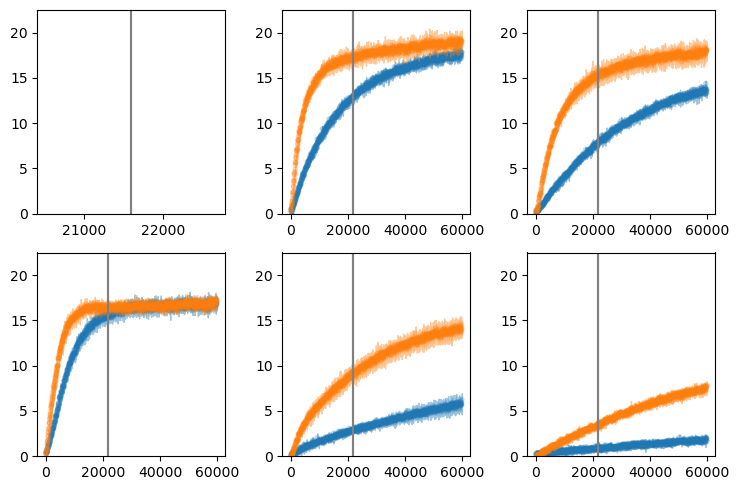

In [55]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_no
data = TUM_no
conditions = conditions_TUM_no

controls = TUM_controls
casc_controls = TUM_casc_controls

conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_no.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'RNA' in level:
    return [1,0]
  if 'no background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)

plt.tight_layout()


TUM_no_nat_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'N25_10uM nat', verbose = True)
TUM_no_nat_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N25_25uM nat', verbose = True)
TUM_no_nat_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_10uM nat', verbose = True)
TUM_no_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
TUM_no_nn_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_10uM nn', verbose = True)
TUM_no_nn_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_25uM nn', verbose = True)
TUM_no_nn_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_10uM nn', verbose = True)
TUM_no_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
TUM_no_diff_N25_10uM = [(TUM_no_nn_N25_10uM[0] - TUM_no_nat_N25_10uM[0]), np.sqrt(TUM_no_nn_N25_10uM[1]**2 + TUM_no_nat_N25_10uM[1]**2)]
TUM_no_diff_N25_25uM = [(TUM_no_nn_N25_25uM[0] - TUM_no_nat_N25_25uM[0]), np.sqrt(TUM_no_nn_N25_25uM[1]**2 + TUM_no_nat_N25_25uM[1]**2)]
TUM_no_diff_N50_10uM = [(TUM_no_nn_N50_10uM[0] - TUM_no_nat_N50_10uM[0]), np.sqrt(TUM_no_nn_N50_10uM[1]**2 + TUM_no_nat_N50_10uM[1]**2)]
TUM_no_diff_N50_25uM = [(TUM_no_nn_N50_25uM[0] - TUM_no_nat_N50_25uM[0]), np.sqrt(TUM_no_nn_N50_25uM[1]**2 + TUM_no_nat_N50_25uM[1]**2)]

print(f"diff_N25_10uM: {TUM_no_diff_N25_10uM[0]} +/- {TUM_no_diff_N25_10uM[1]}")
print(f"diff_N25_25uM: {TUM_no_diff_N25_25uM[0]} +/- {TUM_no_diff_N25_25uM[1]}")
print(f"diff_N50_10uM: {TUM_no_diff_N50_10uM[0]} +/- {TUM_no_diff_N50_10uM[1]}")
print(f"diff_N50_25uM: {TUM_no_diff_N50_25uM[0]} +/- {TUM_no_diff_N50_25uM[1]}")

TUM_no_nat_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM nat', verbose = True)
TUM_no_nn_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM(nn)', verbose = True)
TUM_no_diff_rna_5uM = [(TUM_no_nn_rna_5uM[0] - TUM_no_nat_rna_5uM[0]), np.sqrt(TUM_no_nn_rna_5uM[1]**2 + TUM_no_nat_rna_5uM[1]**2)]
print(f"diff_rna_5uM: {TUM_no_diff_rna_5uM[0]} +/- {TUM_no_diff_rna_5uM[1]}")


## Trigger incubation

In [56]:
t1 = t_TUM_controls
data1 = TUM_controls
conditions1 = conditions_TUM_controls
t2 = t_TUM_casc_controls
data2 = TUM_casc_controls
conditions2 = conditions_TUM_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i,l in enumerate(levels1):
    dfArray.append(getEndpoint(l, t1, data1, conditions1))
for i,l in enumerate(levels2):
    dfArray.append(getEndpoint(l, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
2,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
3,Cascade,16789.3,17054.0,16423.0,16755.433333,258.715369
4,Cascade(nn),16496.0,15884.3,16110.8,16163.700000,252.511425


In [57]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

N25_10uM nat : 0.5085537437257809 +/- 0.034129693503825706
N25_25uM nat : 0.27958700683987403 +/- 0.004986183964334503
N50_10uM nat : 0.10341473563756463 +/- 0.006622887091751495
N50_25uM nat : 0.03662843619151643 +/- 0.01099083420283121
N25_10uM nn : 0.8170967387723729 +/- 0.023163493446652812
N25_25uM nn : 0.7139892390468869 +/- 0.0129412950978774
N50_10uM nn : 0.42786318216756336 +/- 0.02633301551249245
N50_25uM nn : 0.19219281871088176 +/- 0.017555987552574925
diff_N25_10uM: 0.308542995046592 +/- 0.04124782912249093
diff_N25_25uM: 0.4344022322070129 +/- 0.013868639058556977
diff_N50_10uM: 0.3244484465299987 +/- 0.02715309078928689
diff_N50_25uM: 0.15556438251936533 +/- 0.020712583987042517
RNA N183 5uM nat : 0.34496892148448666 +/- 0.011297275193428406
RNA N183 5uM(nn) : 0.3395854464123169 +/- 0.022039838588094763
diff_rna_5uM: -0.005383475072169741 +/- 0.024766568429746658


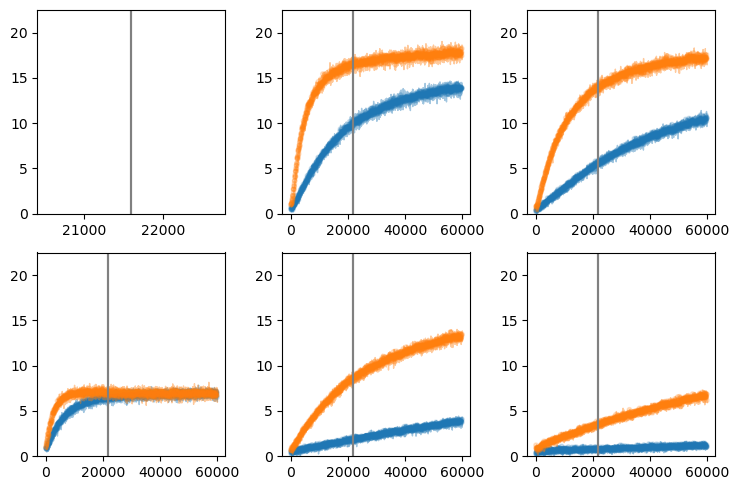

In [58]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_trig
data = TUM_trig
conditions = conditions_TUM_trig

controls = TUM_controls
casc_controls = TUM_casc_controls

conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_trig.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'RNA' in level:
    return [1,0]
  if 'trig background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)

plt.tight_layout()

TUM_trig_nat_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'N25_10uM nat', verbose = True)
TUM_trig_nat_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N25_25uM nat', verbose = True)
TUM_trig_nat_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_10uM nat', verbose = True)
TUM_trig_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
TUM_trig_nn_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_10uM nn', verbose = True)
TUM_trig_nn_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_25uM nn', verbose = True)
TUM_trig_nn_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_10uM nn', verbose = True)
TUM_trig_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
TUM_trig_diff_N25_10uM = [(TUM_trig_nn_N25_10uM[0] - TUM_trig_nat_N25_10uM[0]), np.sqrt(TUM_trig_nn_N25_10uM[1]**2 + TUM_trig_nat_N25_10uM[1]**2)]
TUM_trig_diff_N25_25uM = [(TUM_trig_nn_N25_25uM[0] - TUM_trig_nat_N25_25uM[0]), np.sqrt(TUM_trig_nn_N25_25uM[1]**2 + TUM_trig_nat_N25_25uM[1]**2)]
TUM_trig_diff_N50_10uM = [(TUM_trig_nn_N50_10uM[0] - TUM_trig_nat_N50_10uM[0]), np.sqrt(TUM_trig_nn_N50_10uM[1]**2 + TUM_trig_nat_N50_10uM[1]**2)]
TUM_trig_diff_N50_25uM = [(TUM_trig_nn_N50_25uM[0] - TUM_trig_nat_N50_25uM[0]), np.sqrt(TUM_trig_nn_N50_25uM[1]**2 + TUM_trig_nat_N50_25uM[1]**2)]
print(f"diff_N25_10uM: {TUM_trig_diff_N25_10uM[0]} +/- {TUM_trig_diff_N25_10uM[1]}")
print(f"diff_N25_25uM: {TUM_trig_diff_N25_25uM[0]} +/- {TUM_trig_diff_N25_25uM[1]}")
print(f"diff_N50_10uM: {TUM_trig_diff_N50_10uM[0]} +/- {TUM_trig_diff_N50_10uM[1]}")
print(f"diff_N50_25uM: {TUM_trig_diff_N50_25uM[0]} +/- {TUM_trig_diff_N50_25uM[1]}")

TUM_trig_nat_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM nat', verbose = True)
TUM_trig_nn_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM(nn)', verbose = True)
TUM_trig_diff_rna_5uM = [(TUM_trig_nn_rna_5uM[0] - TUM_trig_nat_rna_5uM[0]), np.sqrt(TUM_trig_nn_rna_5uM[1]**2 + TUM_trig_nat_rna_5uM[1]**2)]
print(f"diff_rna_5uM: {TUM_trig_diff_rna_5uM[0]} +/- {TUM_trig_diff_rna_5uM[1]}")

## Reporter incubation

In [59]:
t1 = t_TUM_controls
data1 = TUM_controls
conditions1 = conditions_TUM_controls
t2 = t_TUM_casc_controls
data2 = TUM_casc_controls
conditions2 = conditions_TUM_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i,l in enumerate(levels1):
    dfArray.append(getEndpoint(l, t1, data1, conditions1))
for i,l in enumerate(levels2):
    dfArray.append(getEndpoint(l, t2, data2, conditions2))
merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,buffer alone,3965.7,3840.1,3885.0,3896.933333,51.965651
1,R alone,4015.6,4016.1,3856.7,3962.800000,75.024307
2,R(nn) alone,4008.1,4251.2,3970.7,4076.666667,124.354609
3,Cascade,16789.3,17054.0,16423.0,16755.433333,258.715369
4,Cascade(nn),16496.0,15884.3,16110.8,16163.700000,252.511425


In [60]:
fit_nat = [3962.800000, (16755.433333-3962.800000)/20]
fit_nn =  [4076.666667, (16163.700000-4076.666667)/20]

N25_10uM nat : 0.626340017164703 +/- 0.023096817132512444
N25_25uM nat : 0.3844477386803984 +/- 0.013882446951811657
N50_10uM nat : 0.12710722738030214 +/- 0.006315716885886224
N50_25uM nat : 0.04219396114535378 +/- 0.007351235149520796
N25_10uM nn : 0.7631272647414077 +/- 0.022139150262488097
N25_25uM nn : 0.6953497309761723 +/- 0.03054228246593847
N50_10uM nn : 0.46160096628966724 +/- 0.01179369614030917
N50_25uM nn : 0.16391786537828046 +/- 0.007586429748277054
diff_N25_10uM: 0.13678724757670468 +/- 0.03199382652946889
diff_N25_25uM: 0.31090199229577387 +/- 0.033549267527012226
diff_N50_10uM: 0.33449373890936507 +/- 0.013378323827468515
diff_N50_25uM: 0.12172390423292667 +/- 0.010563833326453664
RNA N183 5uM nat : 0.3512366388390418 +/- 0.010234853215966294
RNA N183 5uM(nn) : 0.5096460430157862 +/- 0.0184038963275368
diff_rna_5uM: 0.15840940417674437 +/- 0.021058385987228416


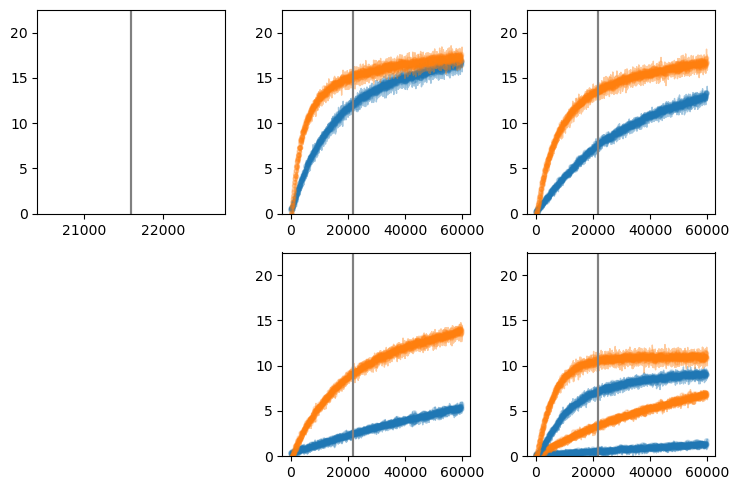

In [61]:
fig,ax = plt.subplots(2,3)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_TUM_casc
data = TUM_casc
conditions = conditions_TUM_casc

controls = TUM_controls
casc_controls = TUM_casc_controls

conditions_levels = list(conditions_TUM_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'no background' in level:
    return [0,0]
  elif 'N25' in level:
    if '10uM' in level:
      return [0,1]
    else:
      return [0,2]
  else:
    if '10uM' in level:
      return [1,1]
    else:
      return [1,2]

def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[ind[0]][ind[1]], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels[3:]):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0][0], controls, conditions_TUM_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels[1:]):
  fit = fits[get_fit_ind(l)]
  for i,row in enumerate(ax):
      for j,a in enumerate(row):
        if not((i,j) == (1,0)):
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)
        else:
          ax[i][j].set_visible(False)


plt.tight_layout()


TUM_casc_nat_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'N25_10uM nat', verbose = True)
TUM_casc_nat_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N25_25uM nat', verbose = True)
TUM_casc_nat_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_10uM nat', verbose = True)
TUM_casc_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
TUM_casc_nn_N25_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_10uM nn', verbose = True)
TUM_casc_nn_N25_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N25_25uM nn', verbose = True)
TUM_casc_nn_N50_10uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_10uM nn', verbose = True)
TUM_casc_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
TUM_casc_diff_N25_10uM = [(TUM_casc_nn_N25_10uM[0] - TUM_casc_nat_N25_10uM[0]), np.sqrt(TUM_casc_nn_N25_10uM[1]**2 + TUM_casc_nat_N25_10uM[1]**2)]
TUM_casc_diff_N25_25uM = [(TUM_casc_nn_N25_25uM[0] - TUM_casc_nat_N25_25uM[0]), np.sqrt(TUM_casc_nn_N25_25uM[1]**2 + TUM_casc_nat_N25_25uM[1]**2)]
TUM_casc_diff_N50_10uM = [(TUM_casc_nn_N50_10uM[0] - TUM_casc_nat_N50_10uM[0]), np.sqrt(TUM_casc_nn_N50_10uM[1]**2 + TUM_casc_nat_N50_10uM[1]**2)]
TUM_casc_diff_N50_25uM = [(TUM_casc_nn_N50_25uM[0] - TUM_casc_nat_N50_25uM[0]), np.sqrt(TUM_casc_nn_N50_25uM[1]**2 + TUM_casc_nat_N50_25uM[1]**2)]
print(f"diff_N25_10uM: {TUM_casc_diff_N25_10uM[0]} +/- {TUM_casc_diff_N25_10uM[1]}")
print(f"diff_N25_25uM: {TUM_casc_diff_N25_25uM[0]} +/- {TUM_casc_diff_N25_25uM[1]}")
print(f"diff_N50_10uM: {TUM_casc_diff_N50_10uM[0]} +/- {TUM_casc_diff_N50_10uM[1]}")
print(f"diff_N50_25uM: {TUM_casc_diff_N50_25uM[0]} +/- {TUM_casc_diff_N50_25uM[1]}")

TUM_casc_nat_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM nat', verbose = True)
TUM_casc_nn_rna_5uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_TUM_controls, conditions_TUM_casc_controls, 'R alone', 'Cascade', 'RNA N183 5uM(nn)', verbose = True)
TUM_casc_diff_rna_5uM = [(TUM_casc_nn_rna_5uM[0] - TUM_casc_nat_rna_5uM[0]), np.sqrt(TUM_casc_nn_rna_5uM[1]**2 + TUM_casc_nat_rna_5uM[1]**2)]
print(f"diff_rna_5uM: {TUM_casc_diff_rna_5uM[0]} +/- {TUM_casc_diff_rna_5uM[1]}")

# Processing UW data

## No incubation

In [62]:
t1 = t_UW_controls
data1 = UW_controls
conditions1 = conditions_UW_controls
t2 = t_UW_casc_controls
data2 = UW_casc_controls
conditions2 = conditions_UW_casc_controls
levels1 = list(conditions1.keys())
levels2 = list(conditions2.keys())

dfArray = []
for i,l in enumerate(levels1):
    dfArray.append(getEndpoint(l, t1, data1, conditions1))
    dfArray.append(getInitial(l, t1, data1, conditions1))

for i,l in enumerate(levels2):
    dfArray.append(getEndpoint(l, t2, data2, conditions2))
    dfArray.append(getInitial(l, t2, data2, conditions2))

merged_df = pd.concat(dfArray, ignore_index=True)
merged_df

,Level,Average 1,Average 2,Average 3,Row Average,Row Std
0,R alone,777.0,783.2,781.6,780.600000,2.628054
1,R alone init,761.1,746.1,760.9,756.033333,7.024402
2,R(nn) alone,274.9,283.0,270.1,276.000000,5.323533
3,R(nn) alone init,244.9,250.6,243.1,246.200000,3.196873
4,Cascade,6017.6,7026.2,5855.3,6299.700000,517.968474
5,Cascade init,4094.2,4987.1,4261.9,4447.733333,387.486020
6,Cascade(nn),4300.4,5246.2,4169.1,4571.900000,479.805718
7,Cascade(nn) init,3536.6,4405.8,3489.7,3810.700000,421.234622


In [63]:
#using baseline measured from untrigged reporter on 2025-06-18
fit_nat = [789.333333, (6299.700000 - 789.333333)/20]
fit_nn =  [278.600000	, (4571.900000	- 278.600000	)/20]

N50_25uM nat : 0.43820278944066415 +/- 0.06199565910589794
N50_25uM nn : 0.792403234236173 +/- 0.08327532948930591
diff_N50_25uM: 0.35420044479550883 +/- 0.10381831365191388


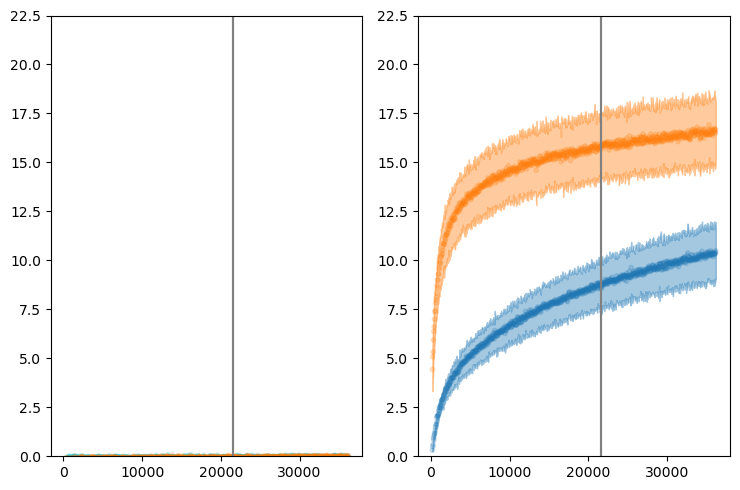

In [64]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_no
data = UW_no
conditions = conditions_UW_no

controls = UW_controls
casc_controls = UW_casc_controls

conditions_levels = list(conditions_UW_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_no.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'R ' in level or 'R(nn)' in level or 'Cascade' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[1], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0], controls, conditions_UW_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  for a in ax:
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)

plt.tight_layout()



UW_no_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
UW_no_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
UW_no_diff_N50_25uM = [(UW_no_nn_N50_25uM[0] - UW_no_nat_N50_25uM[0]), np.sqrt(UW_no_nn_N50_25uM[1]**2 + UW_no_nat_N50_25uM[1]**2)]
print(f"diff_N50_25uM: {UW_no_diff_N50_25uM[0]} +/- {UW_no_diff_N50_25uM[1]}")

## Trigger incubation

In [65]:
#using baseline measured from untrigged reporter on 2025-06-18
fit_nat = [789.333333, (6299.700000 - 789.333333)/20]
fit_nn =  [278.600000	, (4571.900000	- 278.600000	)/20]

N50_25uM nat : 0.41009121181410174 +/- 0.06015267766237351
N50_25uM nn : 0.7399852430288684 +/- 0.06584041301386076
diff_N50_25uM: 0.3298940312147666 +/- 0.08918130194042456


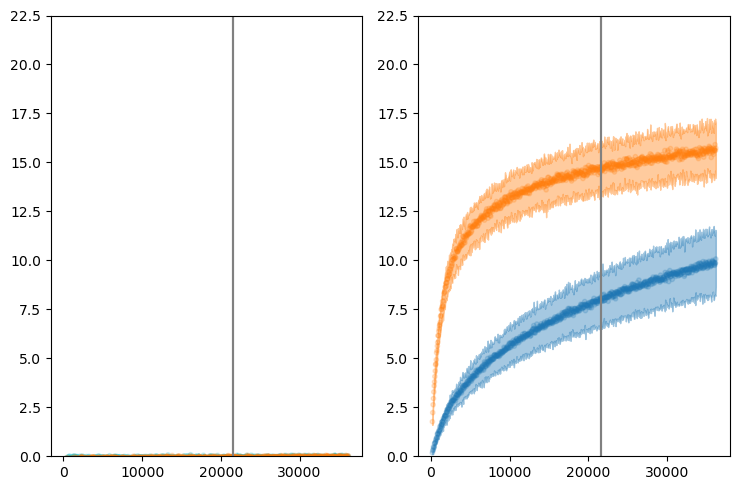

In [66]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_trig
data = UW_trig
conditions = conditions_UW_trig

controls = UW_controls
casc_controls = UW_casc_controls

conditions_levels = list(conditions_UW_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_trig.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'R ' in level or 'R(nn)' in level or 'Cascade' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[1], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0], controls, conditions_UW_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  for a in ax:
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)

plt.tight_layout()



UW_trig_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
UW_trig_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
UW_trig_diff_N50_25uM = [(UW_trig_nn_N50_25uM[0] - UW_trig_nat_N50_25uM[0]), np.sqrt(UW_trig_nn_N50_25uM[1]**2 + UW_trig_nat_N50_25uM[1]**2)]
print(f"diff_N50_25uM: {UW_trig_diff_N50_25uM[0]} +/- {UW_trig_diff_N50_25uM[1]}")

## Reporter incubation

In [67]:
#using baseline measured from untrigged reporter on 2025-06-18
fit_nat = [789.333333, (6299.700000 - 789.333333)/20]
fit_nn =  [278.600000	, (4571.900000	- 278.600000	)/20]

N50_25uM nat : 0.4943052941460355 +/- 0.06240847116266996
N50_25uM nn : 0.9592646109386048 +/- 0.10838366181629025
diff_N50_25uM: 0.4649593167925693 +/- 0.12506732355643413


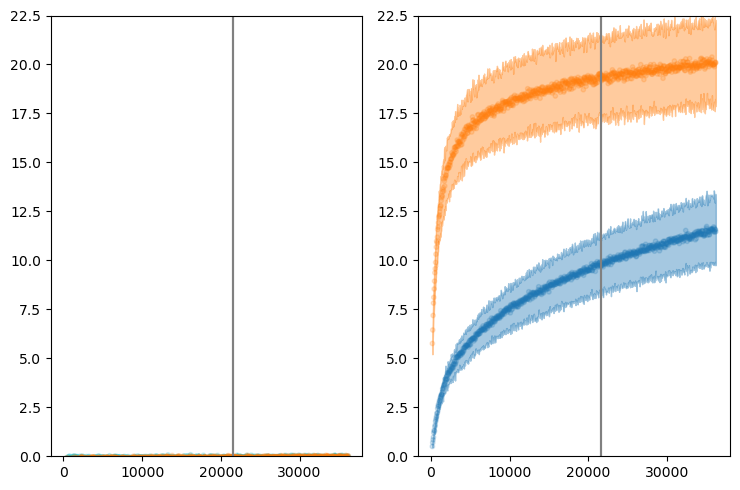

In [68]:
fig,ax = plt.subplots(1,2)
fig.set_figwidth(7.5)
fig.set_figheight(5)

t = t_UW_casc
data = UW_casc
conditions = conditions_UW_casc

controls = UW_controls
casc_controls = UW_casc_controls

conditions_levels = list(conditions_UW_controls.keys())
levels = list(conditions.keys())
fits = [fit_nat, fit_nn]

time_point = 3600*6

format_dict = {'point_size': 10, 'point_opacity': 0.2, 'fill_opacity': 0.4}


def get_color_num(level):
  if 'nat' in level:
    return 0
  elif 'nn' in level:
    return 1
  else:
    return -1
color_dict = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_casc.keys()}
color_dict_controls = {k : color_scheme[get_color_num(k)] for k in conditions_TUM_controls}


def get_plot_num(level):
  if 'R ' in level or 'R(nn)' in level or 'Cascade' in level:
    return 0
  else:
    return 1


def get_fit_ind(level):
  if 'R ' in level or 'nat' in level:
    return 0
  else:
    return 1

dfArray = []
for i,l in enumerate(levels):
    fit = fits[get_fit_ind(l)]
    ind = get_plot_num(l)
    plotCalibratedAverages(l, t, ax[1], data, conditions, fit, color_dict, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  plotCalibratedAverages(l, t, ax[0], controls, conditions_UW_controls, fit, color_dict_controls, format_dict=format_dict)

for k,l in enumerate(conditions_levels):
  fit = fits[get_fit_ind(l)]
  for a in ax:
          a.axvline(x= time_point, color = 'gray')
          a.set_ylim(0,22.5)

plt.tight_layout()



UW_casc_nat_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R alone', 'Cascade', 'N50_25uM nat', verbose = True)
UW_casc_nn_N50_25uM = completion_at_time(data, controls, casc_controls, t, time_point, conditions, conditions_UW_controls, conditions_UW_casc_controls,'R(nn) alone', 'Cascade(nn)', 'N50_25uM nn', verbose = True)
UW_casc_diff_N50_25uM = [(UW_casc_nn_N50_25uM[0] - UW_casc_nat_N50_25uM[0]), np.sqrt(UW_casc_nn_N50_25uM[1]**2 + UW_casc_nat_N50_25uM[1]**2)]
print(f"diff_N50_25uM: {UW_casc_diff_N50_25uM[0]} +/- {UW_casc_diff_N50_25uM[1]}")

# Analysis

## TUM only

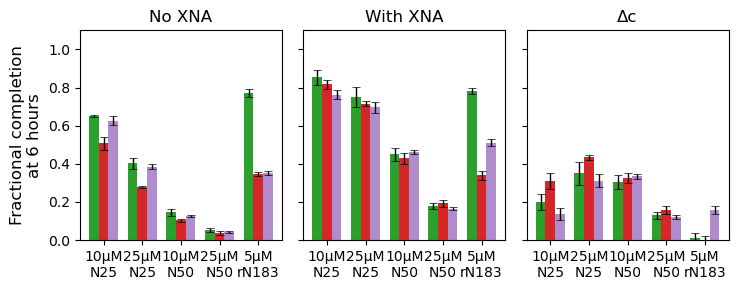

In [71]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(7.5)
fig.set_figheight(3)

labels = [u"10\u03bcM\nN25", u"25\u03bcM\nN25", u"10\u03bcM\nN50", u"25\u03bcM\nN50", u"5\u03bcM\nrN183"]
x = np.arange(len(labels))
bar_width = 0.25

# Each entry: (nat_list, nn_list, diff_list, color, dx, alpha scale)
datasets = [
    (
        [TUM_no_nat_N25_10uM, TUM_no_nat_N25_25uM, TUM_no_nat_N50_10uM, TUM_no_nat_N50_25uM, TUM_no_nat_rna_5uM],
        [TUM_no_nn_N25_10uM,  TUM_no_nn_N25_25uM,  TUM_no_nn_N50_10uM,  TUM_no_nn_N50_25uM, TUM_no_nn_rna_5uM],
        [TUM_no_diff_N25_10uM, TUM_no_diff_N25_25uM, TUM_no_diff_N50_10uM, TUM_no_diff_N50_25uM, TUM_no_diff_rna_5uM],
        color_scheme[2],
        -bar_width,
        1.0
    ),
    (
        [TUM_trig_nat_N25_10uM, TUM_trig_nat_N25_25uM, TUM_trig_nat_N50_10uM, TUM_trig_nat_N50_25uM, TUM_trig_nat_rna_5uM],
        [TUM_trig_nn_N25_10uM,  TUM_trig_nn_N25_25uM,  TUM_trig_nn_N50_10uM,  TUM_trig_nn_N50_25uM, TUM_trig_nn_rna_5uM],
        [TUM_trig_diff_N25_10uM, TUM_trig_diff_N25_25uM, TUM_trig_diff_N50_10uM, TUM_trig_diff_N50_25uM, TUM_trig_diff_rna_5uM],
        color_scheme[3],
        0,
        1.0
    ),
    (
        [TUM_casc_nat_N25_10uM, TUM_casc_nat_N25_25uM, TUM_casc_nat_N50_10uM, TUM_casc_nat_N50_25uM, TUM_casc_nat_rna_5uM],
        [TUM_casc_nn_N25_10uM,  TUM_casc_nn_N25_25uM,  TUM_casc_nn_N50_10uM,  TUM_casc_nn_N50_25uM, TUM_casc_nn_rna_5uM],
        [TUM_casc_diff_N25_10uM, TUM_casc_diff_N25_25uM, TUM_casc_diff_N50_10uM, TUM_casc_diff_N50_25uM, TUM_casc_diff_rna_5uM],
        color_scheme[4],
        bar_width,
        0.75
    ),
]

error_params = dict(ecolor='black', lw=1, capsize=3, capthick= 0.5)


# Panel 0: nat
for nat_list, _, _, color, dx, scale in datasets:
    y = [d[0] for d in nat_list]
    err = [d[1] for d in nat_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=err, color=color, alpha=scale, error_kw=error_params)

# Panel 1: nn
for _, nn_list, _, color, dx, scale in datasets:
    y = [d[0] for d in nn_list]
    err = [d[1] for d in nn_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=err, color=color, alpha=scale, error_kw=error_params)

# Panel 2: diff
for _, _, diff_list, color, dx, scale in datasets:
    y = [d[0] for d in diff_list]
    err = [d[1] for d in diff_list]
    ax[2].bar(x + dx, y, width=bar_width, yerr=err, color=color, alpha=scale, error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=10)
    a.set_ylim(0, 1.1)
    a.tick_params(axis='x', labelrotation=0)

ax[0].set_ylabel('Fractional completion\nat 6 hours', fontsize=12)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Δc', fontsize=12)
plt.tight_layout()
#plt.savefig('NAR_TUM_Casc_3panel_barplot_err.svg', dpi=600)
plt.show()


# Comparison UW to TUM

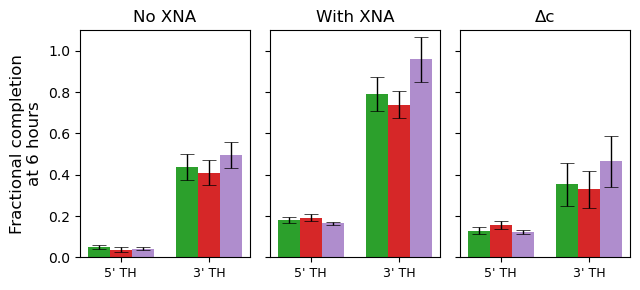

In [73]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 3, sharey=True)
fig.set_figwidth(6.5)
fig.set_figheight(3)

labels = [u"5' TH", u"3' TH"]
x = np.arange(len(labels))
bar_width = 0.25

# Each entry: (nat, nn, diff, color, dx, alpha scale)
datasets = [
    (
        [TUM_no_nat_N50_25uM, UW_no_nat_N50_25uM],
        [TUM_no_nn_N50_25uM, UW_no_nn_N50_25uM],
        [TUM_no_diff_N50_25uM, UW_no_diff_N50_25uM],
        color_scheme[2],
        -bar_width,
        1.0
    ),
    (
        [TUM_trig_nat_N50_25uM, UW_trig_nat_N50_25uM],
        [TUM_trig_nn_N50_25uM, UW_trig_nn_N50_25uM],
        [TUM_trig_diff_N50_25uM, UW_trig_diff_N50_25uM],
        color_scheme[3],
        0,
        1.0
    ),
    (
        [TUM_casc_nat_N50_25uM, UW_casc_nat_N50_25uM],
        [TUM_casc_nn_N50_25uM, UW_casc_nn_N50_25uM],
        [TUM_casc_diff_N50_25uM, UW_casc_diff_N50_25uM],
        color_scheme[4],
        bar_width,
        0.75
    ),
]
error_params = dict(ecolor='black', lw=1, capsize=5, capthick= 0.5)

# Panel 0: nat
for nat_list, _, _, color, dx, scale in datasets:
    y = [v[0] for v in nat_list]
    e = [v[1] for v in nat_list]
    ax[0].bar(x + dx, y, width=bar_width, yerr=e, color=color, alpha=scale, error_kw=error_params)

# Panel 1: nn
for _, nn_list, _, color, dx, scale in datasets:
    y = [v[0] for v in nn_list]
    e = [v[1] for v in nn_list]
    ax[1].bar(x + dx, y, width=bar_width, yerr=e, color=color, alpha=scale, error_kw=error_params)

# Panel 2: diff
for _, _, diff_list, color, dx, scale in datasets:
    y = [v[0] for v in diff_list]
    e = [v[1] for v in diff_list]
    ax[2].bar(x + dx, y, width=bar_width, yerr=e, color=color, alpha=scale, error_kw=error_params)

# Formatting
for a in ax:
    a.set_xticks(x)
    a.set_xticklabels(labels, fontsize=9)
    a.set_ylim(0, 1.1)
    a.tick_params(axis='x')
    
ax[0].set_ylabel('Fractional completion\nat 6 hours', fontsize=12)

ax[0].set_title('No XNA', fontsize=12)
ax[1].set_title('With XNA', fontsize=12)
ax[2].set_title('Δc', fontsize=12)
plt.tight_layout()
#plt.savefig('NAR_cascade_compare_barplot_err.svg', dpi=400)
plt.show()
